### Modeling with UNet

In [1]:
import torch
import torch.nn.functional as F
from torch import optim, nn
from torch.utils.data import DataLoader, random_split

import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import colors

from unet import UNet 
from dataset import HotosmDataset

### Training of the UNet model

In [2]:
# Define the hyperparameters here
learning_rate = 3e-4
batch_size = 8
epochs = 20 # no. of epochs

# Location of the images and mask
data_path = "/Users/savin/Omdena-Projects/HOTOSM/data/Mask/road_mask.npz"

# define the device  here
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
print(f"Using {device}")

# calling dataset class
# This is an effective and clean way to access data based on Pytorch
# DataLoader class will utilize this custom dataset object to split data into batches, shuffle and 
# effective retrieval
train_dataset = HotosmDataset(data_path)
generator = torch.Generator().manual_seed(42) # setting up a manual seed for consistent results
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)
val_dataset, test_dataset = random_split(test_dataset, [0.5, 0.5], generator=generator)

# calling the dataloader
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

print(len(train_dataloader), len(val_dataloader), len(test_dataloader))

Using mps
59 8 8


In [3]:
# Define custom colors for each class
cmap = colors.ListedColormap(['yellow', 'red', 'blue', 'black'])

# Define the normalization boundaries
bounds = [0, 1, 2, 3, 4]  # Upper bound is non-inclusive
norm = colors.BoundaryNorm(bounds, cmap.N)

0it [00:00, ?it/s]

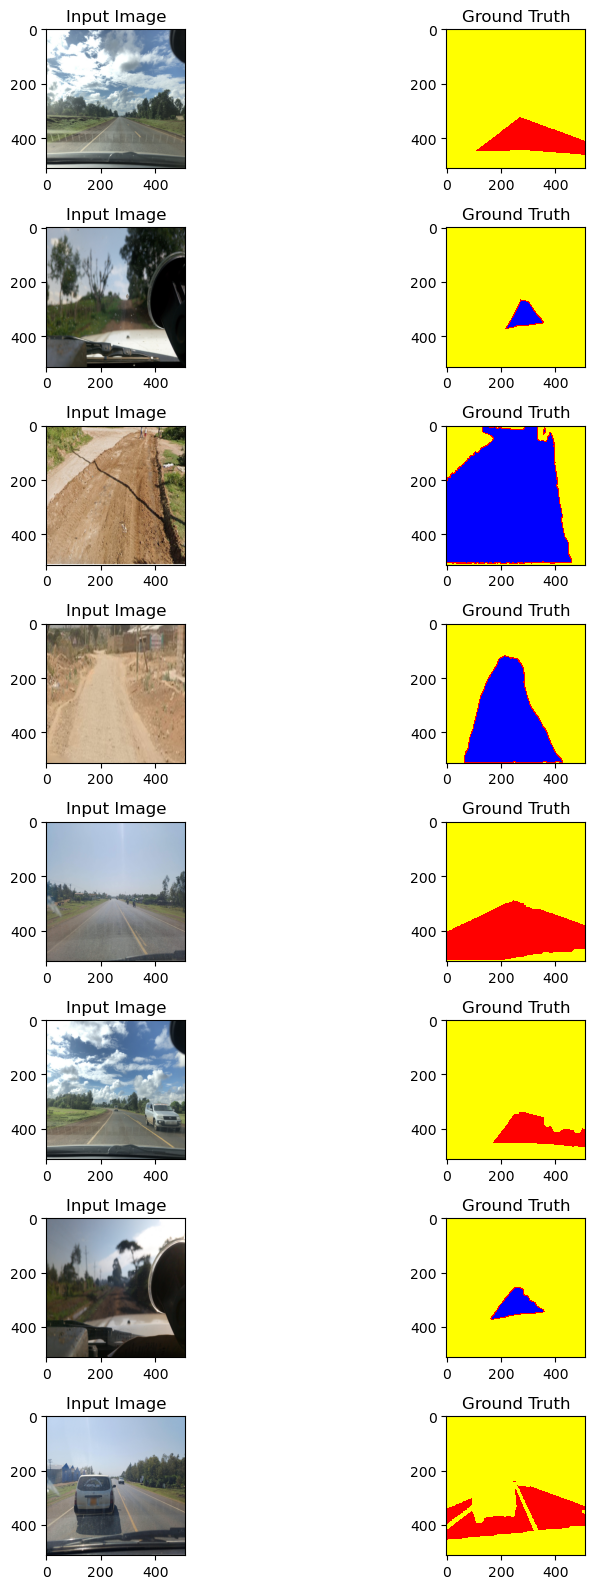

59it [00:01, 30.02it/s]


In [4]:
def visualize_segmentation(images, masks):
    fig, axs = plt.subplots(8, 2, figsize=(10, 16))
    for i in range(8):
        axs[i][0].imshow(images[i].permute(1, 2, 0))
        axs[i][0].set_title("Input Image")
        #print(masks[i].unique())
        axs[i][1].imshow(masks[i], cmap=cmap, norm=norm)
        axs[i][1].set_title("Ground Truth")

    plt.tight_layout()
    plt.show()

for i, (images, masks) in tqdm(enumerate(train_dataloader)):
    if i==0:
        visualize_segmentation(images, masks)

In [5]:
# call the model
# Ideally you want to load all the model and data to the device
# There are 3 classes for Roads: Background, Paved and unpaved

model = UNet(in_channels=3, num_classes=3).to(device) # defining the model
optimizer = optim.AdamW(model.parameters(), lr=learning_rate) # Adam version suited for transformers and UNET architectures.
criterion = nn.CrossEntropyLoss() 

In [6]:
train_losses = []
val_losses = []

for e in range(epochs): # starting the training iterations
    model.train() # setting the model to train mode
    train_running_loss = 0 # calculate loss for each epoch
    print(f"calculating loss across {len(train_dataloader)} batches")

    for img, mask in tqdm(train_dataloader): # data contains the image and mask

        #print(f"Processing epoch:{e}, batch {num}")
        img = img.to(device) # each of this should be [batch_size, channels, height, width]
        
        mask = mask.to(device)

        #print(img.shape, mask.shape)

        ypred = model(img) # This basically outputs the logits and not probabilities. 
        # output shape:  [batch, classes, height, width]
        # mask shape: [batch, height, width] == where pixel value is the index of each class
        # A computational graph is created each during the feed forward network and remeber all the calculations
        # Because CrossEntropyLoss internally does:

        # 1. calculate p = -LogSoftmax(logits) for each pixel
        # 2. loss of single pixel = p[class_index] or selecting -log(softmax(logits)) for the true class
        # 4. Averaging over all the pixels of the image and the batch.
        # 5. Basically generalize the normal multi-class classification along different pixels in an image.

        optimizer.zero_grad() # Zero the gradients in each batch, otherwise they will accumulate

        loss = criterion(ypred, mask) # ypred[nbatch, nclass, height, width], mask:[nbatch, height, width] pixel = 0,1,2...N classes
        train_running_loss += loss.item() # .item is used to convert a 1d tensor to scalar value

        loss.backward() # Back propogation step, calculate the gradient of each parameter and updates the parameter.grad field. 
        # This calculate gradient needs to be cleared after each batch, other wise it will start accumulating.
        optimizer.step() # update the parameters using the calculated gradients in the .grad field of each parameter

        # Delete unnecessary data to free up GPU memory
        del img, mask, ypred, loss

        # Empty unused cache
        torch.mps.empty_cache()

   
    train_loss = train_running_loss/len(train_dataloader) # Average across batches

    train_losses.append(train_loss)

    # Now set the model to the evaluation mode
    model.eval()
    val_running_loss = 0
    with torch.no_grad(): # stop the backpropogation for the evaluation mode and no need to create the compuation graph in the forward run
        for img, mask in tqdm(val_dataloader): # data contains the image and mask
            img = img.to(device)
            mask = mask.to(device)

            ypred = model(img)
            loss = criterion(ypred, mask)

            val_running_loss += loss.item()

            del img, mask, ypred

            # Empty unused cache
            torch.mps.empty_cache()
   
        
        val_loss = val_running_loss/len(val_dataloader)
        val_losses.append(val_loss)
    # print statistics across for each epoch
    print("*"*20)
    print(f"Train loss, epoch {e} : {train_loss:0.4f}")
    print(f"Validation loss, epoch {e} : {val_loss:0.4f}")
    print("*"*20)

calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:09<00:00,  1.18s/it]


********************
Train loss, epoch 0 : 0.9205
Validation loss, epoch 0 : 0.7310
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.22it/s]


********************
Train loss, epoch 1 : 0.6148
Validation loss, epoch 1 : 0.6273
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.23it/s]


********************
Train loss, epoch 2 : 0.6389
Validation loss, epoch 2 : 0.5783
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.20it/s]


********************
Train loss, epoch 3 : 0.5459
Validation loss, epoch 3 : 0.5591
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.22it/s]


********************
Train loss, epoch 4 : 0.5015
Validation loss, epoch 4 : 0.5297
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.25it/s]


********************
Train loss, epoch 5 : 0.4370
Validation loss, epoch 5 : 0.5826
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.21it/s]


********************
Train loss, epoch 6 : 0.3892
Validation loss, epoch 6 : 0.4919
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.27it/s]


********************
Train loss, epoch 7 : 0.3580
Validation loss, epoch 7 : 0.4178
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.16it/s]


********************
Train loss, epoch 8 : 0.3005
Validation loss, epoch 8 : 0.3719
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.29it/s]


********************
Train loss, epoch 9 : 0.2961
Validation loss, epoch 9 : 0.3770
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.31it/s]


********************
Train loss, epoch 10 : 0.2758
Validation loss, epoch 10 : 0.3888
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.24it/s]


********************
Train loss, epoch 11 : 0.2622
Validation loss, epoch 11 : 0.3761
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.26it/s]


********************
Train loss, epoch 12 : 0.2531
Validation loss, epoch 12 : 0.3756
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.28it/s]


********************
Train loss, epoch 13 : 0.2535
Validation loss, epoch 13 : 0.3574
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.25it/s]


********************
Train loss, epoch 14 : 0.2393
Validation loss, epoch 14 : 0.3198
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.17it/s]


********************
Train loss, epoch 15 : 0.2321
Validation loss, epoch 15 : 0.3700
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.27it/s]


********************
Train loss, epoch 16 : 0.2214
Validation loss, epoch 16 : 0.3138
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.28it/s]


********************
Train loss, epoch 17 : 0.2164
Validation loss, epoch 17 : 0.3202
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.22it/s]


********************
Train loss, epoch 18 : 0.2229
Validation loss, epoch 18 : 0.4556
********************
calculating loss across 59 batches


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.28it/s]

********************
Train loss, epoch 19 : 0.2139
Validation loss, epoch 19 : 0.3591
********************


### Model Evaluation

In [7]:
# save the model to
model_save_path = "models/"

# save the history as a data frame
df = pd.DataFrame(data={"train_loss":train_losses, "val_loss":val_losses})
df.to_csv(model_save_path+"hist_roads.csv")

#save pytorch model
#torch.save(model.state_dict(),  model_save_path)
# save to torchscript format, no model defining is needed
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save(model_save_path+'unet_roads.pt') # Save

In [8]:
hist = pd.read_csv("models/hist_roads.csv")
hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  20 non-null     int64  
 1   train_loss  20 non-null     float64
 2   val_loss    20 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 608.0 bytes


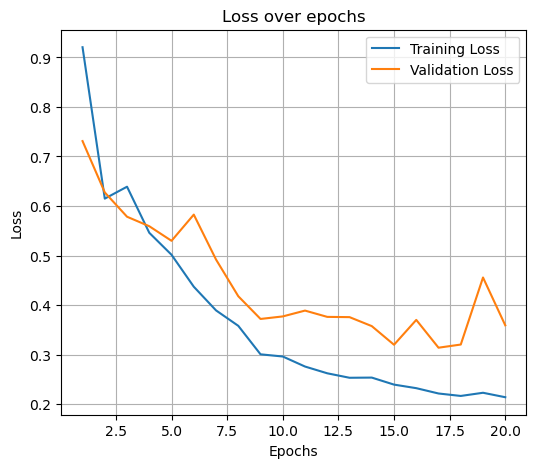

In [9]:
train_loss = hist['train_loss']
val_loss = hist['val_loss']

n_epochs = len(train_loss)

epochs_list = list(range(1, n_epochs + 1))

plt.figure(figsize=(6, 5))

plt.plot(epochs_list, train_loss, label='Training Loss')
plt.plot(epochs_list, val_loss, label='Validation Loss')
#plt.xticks(ticks=list(range(1, EPOCHS + 1, 1))) 
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Metric calculation
Mainly 3 metrics can be used here:
1. Dice score - Measure the overlap between the predicted segment and the ground truth segment. Ranges from 0-1.
   score = 2 * (A interesection B) / (A + B) = 2* (common pixels)/ (no of pixels in A + no of pixels in B). Emphasis overlap heavily
3. IOU = Intersection over Union. How much predicted and ground truth intersect relative to their union. Usually lower than the dice score. Penalizes false positives and false negatives more directly.
4. Pixel accuracy = Percentage of correctly classfied pixels in an image wrt to ground truth labels.

In [10]:
# Calculation of the metrics

def compute_multiclass_metrics(outputs, targets, num_classes, eps=1e-6):
    """
    Computes Dice, IoU, and Pixel Accuracy for multi-class segmentation.

    Args:
        outputs: model logits or softmax outputs, shape [B, C, H, W]
        targets: ground truth, shape [B, H, W] with values 0...C-1
    """
    preds = torch.argmax(outputs, dim=1)  # shape [B, H, W]

    dice_scores = []
    iou_scores = []
    pixel_accs = []

    for cls in range(num_classes):
        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()

        intersection = (pred_cls * target_cls).sum(dim=(1, 2))
        union = pred_cls.sum(dim=(1, 2)) + target_cls.sum(dim=(1, 2))
        dice = (2. * intersection + eps) / (union + eps)

        iou = (intersection + eps) / (
            pred_cls.sum(dim=(1, 2)) + target_cls.sum(dim=(1, 2)) - intersection + eps
        )

        dice_scores.append(dice.mean().item()) # average dice score of all images within a batch
        iou_scores.append(iou.mean().item())  # average iou score of all images within a batch

    # Pixel Accuracy over all images 
    pixel_acc = (preds == targets).float().mean().item() 

    return {
        'mean_dice': sum(dice_scores) / num_classes,
        'mean_iou': sum(iou_scores) / num_classes,
        'pixel_accuracy': pixel_acc,
        'per_class_dice': dice_scores,
        'per_class_iou': iou_scores
    }

In [ ]:
#model = torch.jit.load("models/unet_roads.pt")

### Model Evaluation on Validation and Test data

In [11]:
model.eval()
val_metrics_list = []

with torch.no_grad():
    for images, masks in tqdm(val_dataloader):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)  # Shape: [B, C, H, W]

        metrics = compute_multiclass_metrics(outputs, masks, num_classes=3)
        val_metrics_list.append(metrics)

100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.21it/s]


In [12]:
model.eval()
test_metrics_list = []

with torch.no_grad():
    for images, masks in tqdm(test_dataloader):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)  # Shape: [B, C, H, W]

        metrics = compute_multiclass_metrics(outputs, masks, num_classes=3)
        test_metrics_list.append(metrics)

100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.28it/s]


In [13]:
def print_metrics(metrics_list):
    # Average the metrics across all batches
    avg_mean_dice = np.array([metric['mean_dice'] for metric in metrics_list]).mean()
    avg_mean_iou = np.array([metric['mean_iou'] for metric in metrics_list]).mean()
    avg_pix_accuracy = np.array([metric['pixel_accuracy'] for metric in metrics_list]).mean()
    avg_per_class_dice = np.array([metric['per_class_dice'] for metric in metrics_list]).mean(axis=0)
    avg_per_class_iou = np.array([metric['per_class_iou'] for metric in metrics_list]).mean(axis=0)
    
    print("Metric averaged over batches")
    print(f"Dice (averaged over class) - batch average: {avg_mean_dice:.4f}")
    print(f"IoU (averaged over class) - batch average: {avg_mean_iou:.4f}")
    print(f"Pixel Accuracy - batch average : {avg_pix_accuracy:.4f}")
    print(f"Per class dice - batch average: {np.round(avg_per_class_dice, 4)}")
    print(f"Per class IoU - batch average: {np.round(avg_per_class_iou, 4)}")

In [14]:
print_metrics(val_metrics_list)

Metric averaged over batches
Dice (averaged over class) - batch average: 0.5054
IoU (averaged over class) - batch average: 0.4653
Pixel Accuracy - batch average : 0.8706
Per class dice - batch average: [0.8325 0.446  0.2378]
Per class IoU - batch average: [0.7745 0.41   0.2114]


In [15]:
print_metrics(test_metrics_list)

Metric averaged over batches
Dice (averaged over class) - batch average: 0.6057
IoU (averaged over class) - batch average: 0.5659
Pixel Accuracy - batch average : 0.9367
Per class dice - batch average: [0.9114 0.5457 0.36  ]
Per class IoU - batch average: [0.8572 0.5    0.3404]


As we noticed earlier, the metric are slightly better for the test data compared to the validation data.

### Visualization of the Test Results

3it [00:02,  1.23it/s]

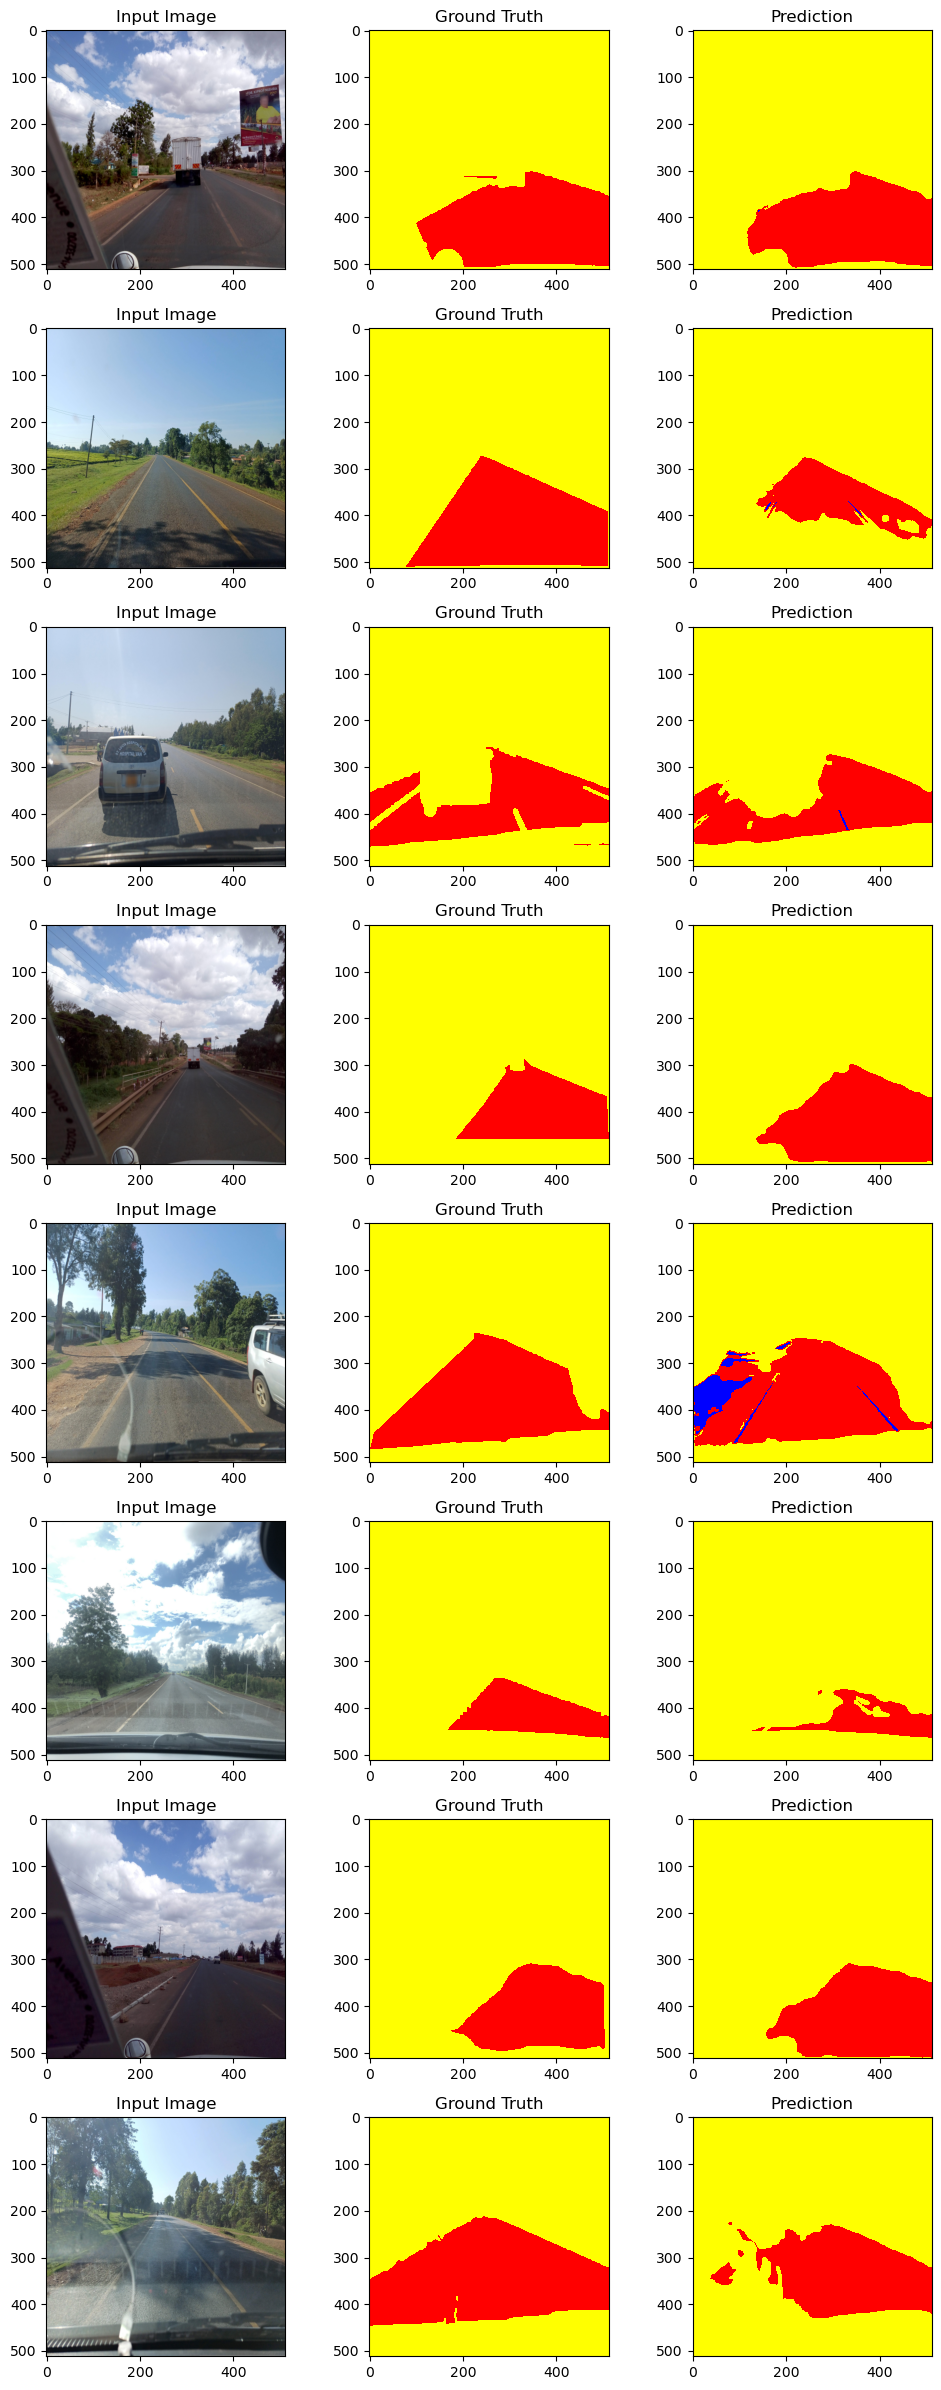

8it [00:07,  1.01it/s]


In [17]:
def visualize_segmentation(images, masks, preds, class_names=None):
    images = images.cpu()
    masks = masks.cpu()
    #print(np.unique(masks))
    preds = preds.cpu()
    #print(np.unique(preds))

    fig, axs = plt.subplots(len(images), 3, figsize=(10, 3 * len(images)))
    if len(images) == 1:
        axs = [axs]

    for i in range(len(images)):
        axs[i][0].imshow(images[i].permute(1, 2, 0))
        axs[i][0].set_title("Input Image")
        axs[i][1].imshow(masks[i], cmap=cmap, norm=norm)
        axs[i][1].set_title("Ground Truth")
        axs[i][2].imshow(preds[i], cmap=cmap, norm=norm)
        axs[i][2].set_title("Prediction")

    plt.tight_layout()
    plt.show()


with torch.no_grad():
    for i, (images, masks) in tqdm(enumerate(test_dataloader)):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)  # Shape: [B, C, H, W]
        preds = torch.argmax(outputs, dim=1)

        if i==3:
            visualize_segmentation(images, masks, preds)